In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle, islice, chain, repeat
from os import listdir, path
from os.path import isfile, join
from PIL import Image
import numpy as np
import math
from datetime import datetime
from pathos.multiprocessing import cpu_count, ProcessingPool

In [27]:
def red(image):
    image = image.convert('RGBA')
    arr = np.asarray(image).copy()
    rgb = arr[:,:,1:3]
    arr[:,:,1:3][np.where(rgb == 255)] = 0
    red_image = Image.new(mode='RGBA', size=image.size, color=1)
    red_image.paste(Image.fromarray(arr))
    
    return red_image


def black(image):
    image = image.convert('RGBA')
    arr = np.asarray(image).copy()
    rgb = arr[:,:,0:3]
    arr[:,:,0:3][np.where(rgb == 255)] = 0
    red_image = Image.new(mode='RGBA', size=image.size, color=1)
    red_image.paste(Image.fromarray(arr))
    
    return red_image


def load_rank_samples(rank_images_dir):
    for name in listdir(rank_images_dir):
        full_path = join(rank_images_dir, name)
        if not isfile(full_path):
            continue

        rank = path.splitext(path.basename(full_path))[0]
        image = Image.open(full_path)
        red_image = red(image)
        black_image = black(image)

        yield (red_image, rank)
        yield (black_image, rank)


def warp(image, angle, center, new_center, scale):
    angle = -angle/180.0*math.pi
    nx,ny = x,y = center
    sx=sy=1.0
    (nx,ny) = new_center
    (sx,sy) = scale
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    
    return image.transform(image.size, Image.AFFINE, (a,b,c,d,e,f))


def warp_rnd(image, rnd_level=.2):
    r = lambda v: v * (.5 - np.random.rand())
    width, height = image.size
    
    angle = r(20)
    center = width/2 + r(width/10), height/2 + r(height/10)
    new_center = width/2 + r(width/20), height/2 + r(height/20)
    scale = 1 + r(.3), 1 + r(.3)
    
    return warp(image, angle, center, new_center, scale)


def gen_rank_samples(rank_images_dir, count, rnd_level=.2):
    samples = list(load_rank_samples('res/cards/rank'))
    samples = [(warp_rnd(image, rnd_level), label) for (image, label) in islice(cycle(samples), 0, count)]
    images, labels = zip(*samples)
    return images, labels


def gen_rank_samples_mp(rank_images_dir, count, rnd_level=.2):
    pool = ProcessingPool(8)
    for (img, rank) in load_rank_samples('res/cards/rank'):
        images = pool.map(lambda i: warp_rnd(img), range(0, count/26))
        labels = repeat(rank, count/26)

In [28]:
start = datetime.now()
rank_images, rank_labels = gen_rank_samples('res/cards/rank', 50000)
finish = datetime.now()
print('ST Elapsed: %s' % (finish - start))

start = datetime.now()
samples = gen_rank_samples_mp('res/cards/rank', 50000)
finish = datetime.now()
print('MP Elapsed: %s' % (finish - start))

ST Elapsed: 0:00:02.168001
MP Elapsed: 0:00:04.700853


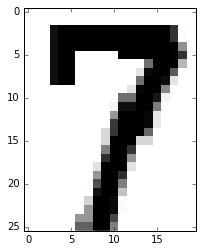

In [35]:
rank_images, rank_labels = gen_rank_samples('res/cards/rank', 50)
plt.imshow(rank_images[41], interpolation='none')

In [ ]:
def preprocess(image):
    warped_image = warp(image)
    return np.asarray(warped_image)

In [ ]:
def card_rank_model_fn(features, labels, mode, params, config):
    pass

def card_rank_train_input_fn(steps, batch_count, batch_size):
    (images, labels) = load_rank_images()
    
    stop = steps * batch_count * batch_size
    
    images = [preprocess(image) for image in islice(cycle(images), 0, stop)]
    labels = [label for label in islice(cycle(images), 0, stop)]
    
    return (images, labels)

def card_rank_eval_input_fn():
    pass

In [ ]:
classifier = tf.estimator.Estimator(
    model_fn = card_rank_model_fn,
    model_dir = 'models/card_rank'
)

train_steps = 1000
train_batch_count = 100
train_batch_size = 100

classifier.train(
    input_fn = lambda: card_rank_train_input_fn(train_steps, train_batch_count, train_batch_size),
    steps = train_steps
)

metrics = classifier.evaluate(
    input_fn = card_rank_eval_input_fn
)

print('Accuracy: {accuracy:0.3f}'.format(**metrics))